# Geographic Data Science with Python - Report 5

---

## Section 1: Summary of Readings

### Chapter 6: Global Spatial Autocorrelation

#### What is Spatial Autocorrelation?
- Measures how values at one location relate to those nearby.
- Opposite of spatial randomness, where location tells us nothing about values.
- Two types:
  - **Positive**: Similar values cluster (e.g., wealthy areas near each other).
  - **Negative**: Dissimilar values are neighbors (e.g., competing stores avoid each other).
- Can be:
  - **Global**: Measures overall tendency.
  - **Local**: Measures location-specific patterns (see Chapter 7).

### Key Concepts & Tools

#### 1. Spatial Lag
- A spatial lag is the weighted average of neighboring values.
- For location *i*, spatial lag = sum of (weight between *i* and *j*) × (value at *j*).
- In matrix notation: SpatialLag = W × Y
- Captures how values are influenced by their spatial context.

#### 2. Binary Case: Join Counts
- Converts the variable into binary form (e.g., Leave vs Remain).
- Counts how often similar neighbors appear:
  - GG: both neighbors are in group G
  - YY: both are in group Y
  - GY: one in each
- Compare observed vs expected under randomness.
- Excess similar joins → evidence of positive spatial autocorrelation.

#### 3. Continuous Case

##### Moran Plot
- Plot of standardized values vs. their spatial lags.
- The slope of the line indicates the level of spatial autocorrelation.
  - Steeper positive slope = stronger positive autocorrelation.

##### Moran’s I
- Summary index of spatial autocorrelation for continuous data.
- Formula involves:
  - Number of observations (n)
  - Spatial weights
  - Standardized values (z-scores)
- Typical values:
  - Close to +1: strong positive clustering
  - Around 0: spatial randomness
  - Negative: dispersion
- Significance tested via random permutations.

#### 4. Other Global Indices
- **Geary’s C**:
  - Based on squared differences between neighbors.
  - Focuses more on local variability than Moran’s I.
  - Value close to 1 indicates randomness.
- **Getis-Ord G**:
  - Measures clustering of high or low values (hot spots and cold spots).
  - Cannot detect negative spatial autocorrelation.
  - Sensitive to distance rather than neighborhood structure.

#### Case Study: Brexit Vote
- Variable: Percent of Leave votes by local authority in the UK.
- Strong global spatial autocorrelation detected:
  - Join counts: revealed clustering.
  - Moran’s I ≈ 0.645 (high clustering).
  - Geary’s C ≈ 0.41 (low local variability).
  - Getis-Ord G ≈ 0.434 (significant hot spots).
- Conclusion: spatial patterns were unlikely to occur by chance.

### Conclusion
- Global spatial autocorrelation helps detect whether values cluster across space.
- Important for checking assumptions before spatial modeling.
- Prepares the way for **local** analysis, where we examine *where* clustering occurs.


## Section 2: Working With Python
### An empirical illustration: the EU Referendum

In [212]:
# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

In [213]:
data_root = "C:/Users/riley/Desktop/book/"
brexit_data_path = data_root + "/data/brexit/brexit_vote.csv"
ref = pandas.read_csv(brexit_data_path, index_col="Area_Code")
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, E06000031 to E08000036
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       382 non-null    int64  
 1   Region_Code              382 non-null    object 
 2   Region                   382 non-null    object 
 3   Area                     382 non-null    object 
 4   Electorate               382 non-null    int64  
 5   ExpectedBallots          382 non-null    int64  
 6   VerifiedBallotPapers     382 non-null    int64  
 7   Pct_Turnout              382 non-null    float64
 8   Votes_Cast               382 non-null    int64  
 9   Valid_Votes              382 non-null    int64  
 10  Remain                   382 non-null    int64  
 11  Leave                    382 non-null    int64  
 12  Rejected_Ballots         382 non-null    int64  
 13  No_official_mark         382 non-null    int64  
 14  Voting_for_both_a

In [214]:
lads = geopandas.read_file(
    data_root + "/data/brexit/local_authority_districts.geojson"
).set_index("lad16cd")
lads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 391 entries, E06000001 to W06000023
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    391 non-null    int32   
 1   lad16nm     391 non-null    object  
 2   lad16nmw    22 non-null     object  
 3   bng_e       391 non-null    int32   
 4   bng_n       391 non-null    int32   
 5   long        391 non-null    float64 
 6   lat         391 non-null    float64 
 7   st_areasha  391 non-null    float64 
 8   st_lengths  391 non-null    float64 
 9   geometry    391 non-null    geometry
dtypes: float64(4), geometry(1), int32(3), object(2)
memory usage: 29.0+ KB


In [215]:
db = (
    geopandas.GeoDataFrame(
        lads.join(ref[["Pct_Leave"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[
        ["objectid", "lad16nm", "Pct_Leave", "geometry"]
    ]
    .dropna()
)
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int32   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int32(1), object(1)
memory usage: 13.4+ KB


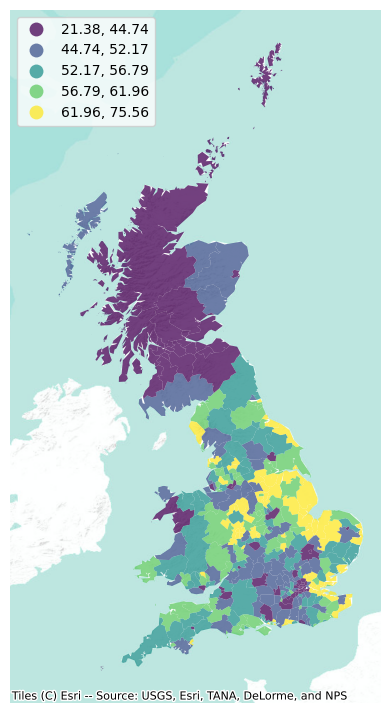

In [216]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax.set_axis_off()

In [217]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

### Global spatial autocorrelation

#### Spatial lag

In [218]:
db["Pct_Leave_lag"] = weights.spatial_lag.lag_spatial(
    w, db["Pct_Leave"]
)

In [219]:
db.loc[["E08000012", "S12000019"], ["Pct_Leave", "Pct_Leave_lag"]]

,Pct_Leave,Pct_Leave_lag
lad16cd,,
E08000012,41.81,54.61375
S12000019,37.94,38.01875


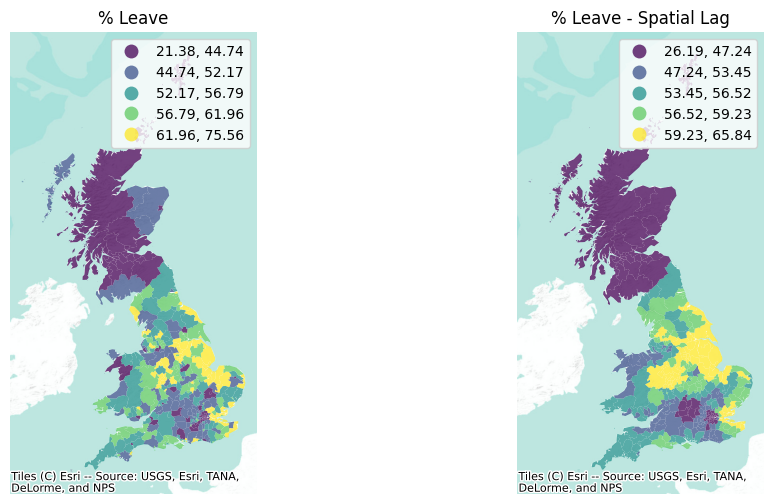

In [220]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("% Leave")
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

db.plot(
    column="Pct_Leave_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("% Leave - Spatial Lag")
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

plt.show()

#### Binary case: join counts

In [221]:
db["Leave"] = (db["Pct_Leave"] > 50).astype(int)
db[["Pct_Leave", "Leave"]].tail()

,Pct_Leave,Leave
lad16cd,,
W06000018,57.63,1
W06000019,62.03,1
W06000021,49.56,0
W06000022,55.99,1
W06000023,53.74,1


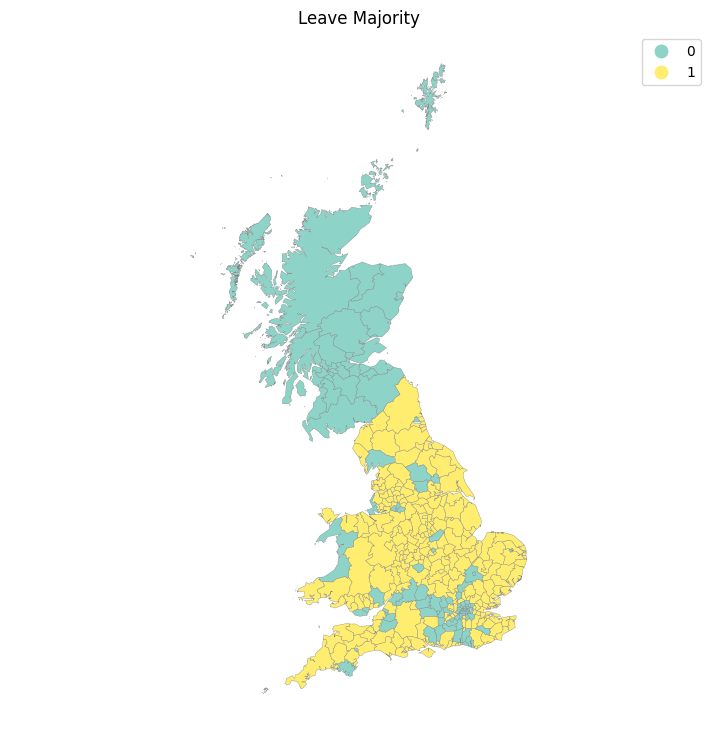

In [222]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    ax=ax,
    column="Leave",
    categorical=True,
    legend=True,
    edgecolor="0.5",
    linewidth=0.25,
    cmap="Set3",
    figsize=(9, 9),
)
ax.set_axis_off()
ax.set_title("Leave Majority")
plt.axis("equal")
plt.show()

In [223]:
w.transform

'R'

In [224]:
w.transform = "O"

In [225]:
w.transform

'O'

In [226]:
seed(1234)
jc = esda.join_counts.Join_Counts(db["Leave"], w)
jc

In [227]:
jc.bb

np.float64(871.0)

In [228]:
jc.ww

np.float64(302.0)

In [229]:
jc.bw

np.float64(347.0)

In [230]:
jc.bb + jc.ww + jc.bw

np.float64(1520.0)

In [231]:
jc.J

np.float64(1520.0)

In [232]:
jc.mean_bb

np.float64(727.4124124124124)

In [233]:
jc.mean_bw

np.float64(649.3233233233233)

In [234]:
jc.p_sim_bb

np.float64(0.001)

In [235]:
jc.p_sim_bw

np.float64(1.0)

#### Continuous case: Moran Plot and Moran’s I

In [236]:
db["Pct_Leave_std"] = db["Pct_Leave"] - db["Pct_Leave"].mean()
db["Pct_Leave_lag_std"] = weights.lag_spatial(
    w, db["Pct_Leave_std"]
)

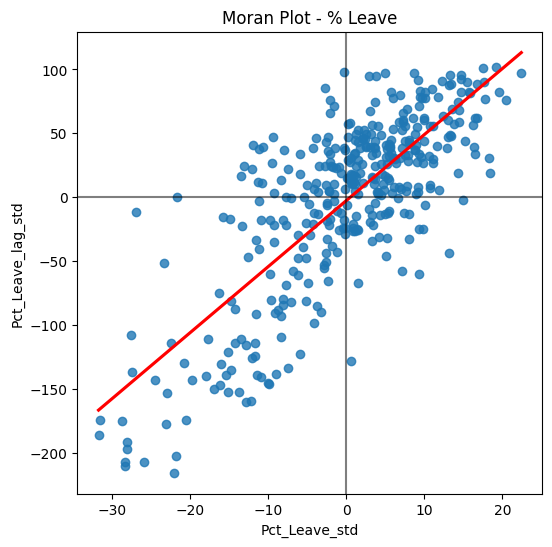

In [237]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="Pct_Leave_std",
    y="Pct_Leave_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - % Leave")
plt.show()

In [238]:
w.transform = "R"
moran = esda.moran.Moran(db["Pct_Leave"], w)

In [239]:
moran.I

np.float64(0.6454521298096587)

In [240]:
moran.p_sim

np.float64(0.001)

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.65', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.65)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

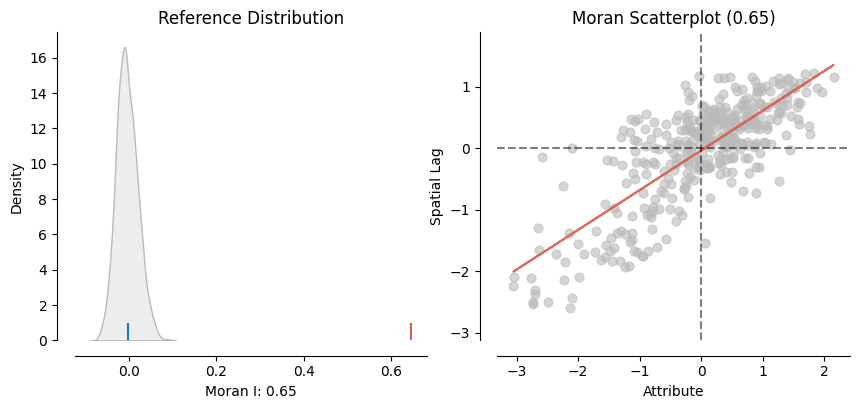

In [241]:
plot_moran(moran)

#### Other global indices

In [242]:
geary = esda.geary.Geary(db["Pct_Leave"], w)

In [243]:
geary.C

np.float64(0.4080233215854691)

In [244]:
geary.p_sim

np.float64(0.001)

In [245]:
db_osgb = db.to_crs(epsg=27700)
pts = db_osgb.centroid
xys = pandas.DataFrame({"X": pts.x, "Y": pts.y})
min_thr = weights.util.min_threshold_distance(xys)
min_thr

np.float64(180878.91800926058)

In [246]:
w_db = weights.DistanceBand.from_dataframe(db_osgb, min_thr)

In [247]:
gao = esda.getisord.G(db["Pct_Leave"], w_db)

In [248]:
print(
    "Getis & Ord G: %.3f | Pseudo P-value: %.3f" % (gao.G, gao.p_sim)
)

Getis & Ord G: 0.434 | Pseudo P-value: 0.003


## Section 3 - Assignment

Analyze crime incident clustering using Moran’s I and Getis-Ord. Visualize results on a map.

In [249]:
# 1. Import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen
from shapely.geometry import box
import certifi
import requests
from io import BytesIO

In [250]:
# Data source: https://data.sfgov.org/Public-Safety/Map-of-Police-Department-Incident-Reports-2018-to-/jq29-s5wp
url = (
    "https://data.sfgov.org/resource/wg3w-h783.geojson?"
    "$where=incident_date >= '2025-07-01T00:00:00' AND incident_date < '2025-08-01T00:00:00'"
)
response = requests.get(url, verify=certifi.where())
crime = gpd.read_file(BytesIO(response.content))

Skipping field incident_time: unsupported OGR type: 10


In [251]:
# Drop rows with invalid geometry
crime = crime.dropna(subset=["geometry"])

# Reproject to Web Mercator for mapping and spatial grid operations
crime = crime.to_crs(epsg=3857)


In [252]:
# Create Spatial Grid anf Count Crimes

# Define bounds and grid
xmin, ymin, xmax, ymax = crime.total_bounds
grid_size = 250  # meters
cols = list(range(int(xmin), int(xmax), grid_size))
rows = list(range(int(ymin), int(ymax), grid_size))

polygons = [
    box(x, y, x + grid_size, y + grid_size)
    for x in cols for y in rows
]

grid = gpd.GeoDataFrame(geometry=polygons, crs=crime.crs)

# Spatial join: count crimes per grid cell
join = gpd.sjoin(crime, grid, predicate='within', how='left')
grid['crime_count'] = join.groupby('index_right').size()
grid['crime_count'] = grid['crime_count'].fillna(0)


In [253]:
# Moran's I Spatial Autocorrelation

w = Queen.from_dataframe(grid, use_index=False)
w.transform = 'r'

moran = Moran(grid['crime_count'], w)
print(f"Moran's I: {moran.I:.4f}, p-value: {moran.p_sim:.4f}")

Moran's I: 0.3478, p-value: 0.0010


In [254]:
# Getis-Ord Gi* Spatial Autocorrelation

g_local = G_Local(grid['crime_count'], w)
grid['GiZ'] = g_local.Zs
grid['GiSig'] = g_local.p_sim < 0.05

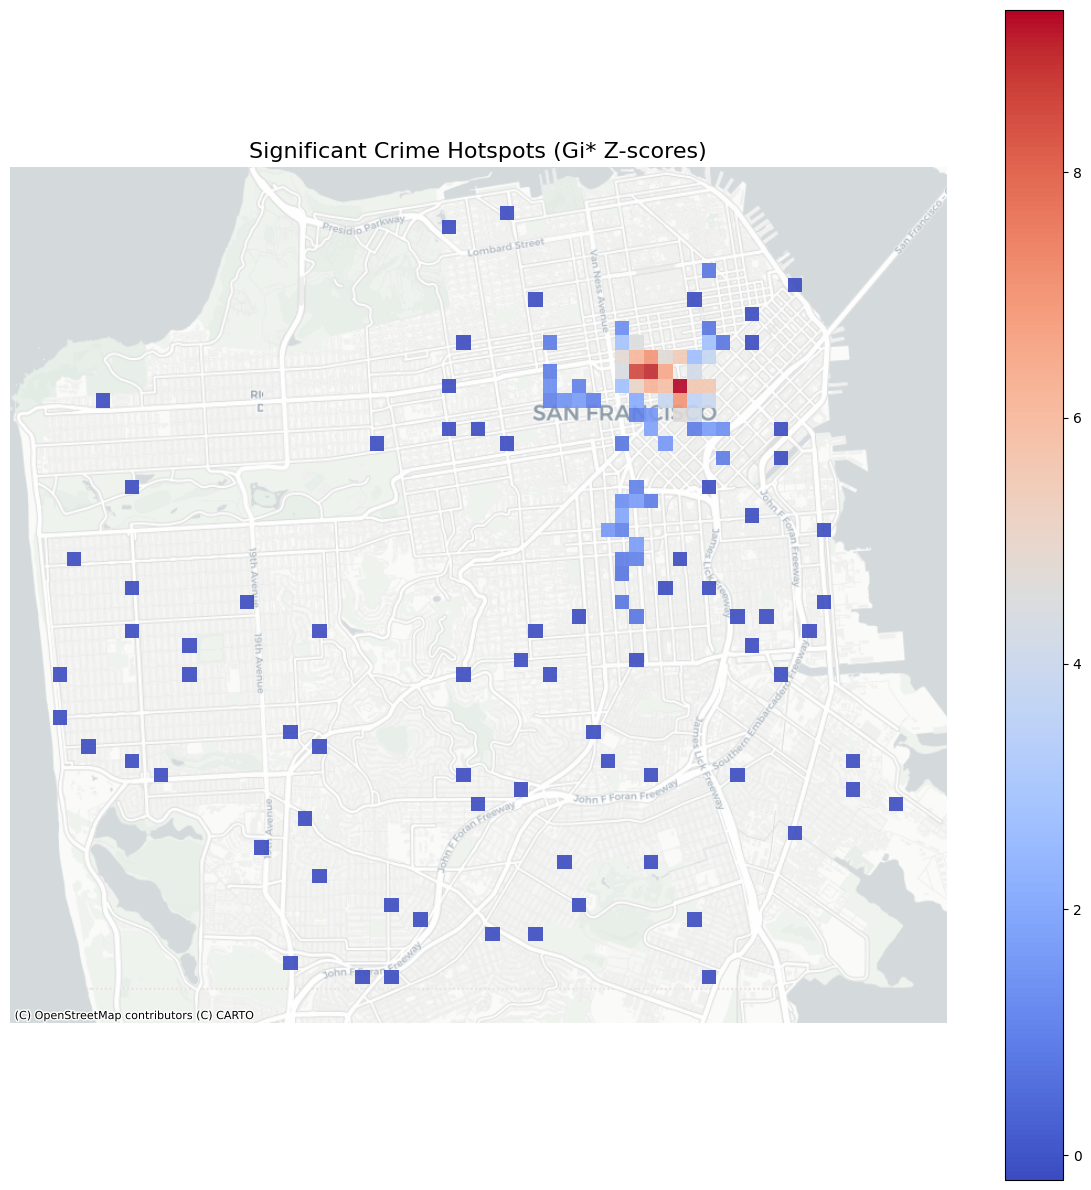

In [255]:
# Visualize the crime data

# Filter for significant hotspots with nonzero crime
hotspots = grid[(grid['GiSig']) & (grid['crime_count'] > 0)]

fig, ax = plt.subplots(figsize=(12, 12))

# Plot only statistically significant, nonzero-count cells
hotspots.plot(
    column='GiZ',
    cmap='coolwarm',
    legend=True,
    ax=ax,
    linewidth=0,
    alpha=0.9
)

# Add basemap under hotspots
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=13)

# Aesthetic tweaks
ax.set_title("Significant Crime Hotspots (Gi* Z-scores)", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()


